# Graph Cut Search Problem with Grover Oracle

The "Maximum Cut Problem" (MaxCut) [[1](#MaxCutWiki)] is an example of a combinatorial optimization problem. It refers to finding a partition of a graph into two sets, such that the number of edges between the two sets is the maximum.

## Mathematical Formulation

Given a graph $G=(V,E)$ with $|V|=n$ nodes and $E$ edges, a cut is defined as a partition of the graph into two complementary subsets of nodes. In the MaxCut problem we look for a cut where the number of edges between the two subsets is the maximum. We can represent a cut of the graph by a binary vector $x$ of size $n$, assigning 0 and 1 to nodes in the first and second subsets, respectively. The number of connecting edges for a given cut is simply given by summing over $x_i (1-x_j)+x_j (1-x_i)$ for every pair of connected nodes $(i,j)$.

## Solving with the Classiq Platform


In this tutorial we define a **search problem** instead: Given a graph and number of edges, we check if there is a cut in the graph larger than a certain size. We solve the problem using the Grover algorithm.

### Defining a Specific Problem Input

We initiate a specific graph whose maximum cut is 5:

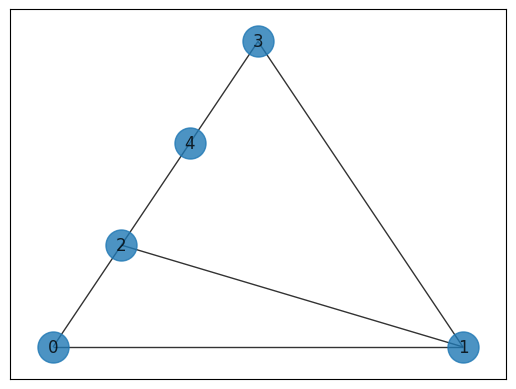

In [1]:
import networkx as nx

# Create graph
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)])
pos = nx.planar_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=True, alpha=0.8, node_size=500)

## Creating a Quantum Circuit and Solving It Using the Classiq Platform

We use the `grover_search` function for the quantum circuit. The oracle function is a `phase_oracle`, which applies a $(-1)$ phase to each state for which the inner function delivered to `phase_oracle` returns 1. The `cut_oracle` is the inner function in this case, calculating whether a given graph partition`s cut is larger than some constant.


Here we look for a cut of size 4 to the graph:

In [2]:
from classiq import *

CUT_SIZE = 4


# cut formulas
def is_cross_cut_edge(x1: int, x2: int) -> int:
    return x1 * (1 - x2) + x2 * (1 - x1)


def cut(x):
    return sum(is_cross_cut_edge(x[node1], x[node2]) for (node1, node2) in G.edges)


# quantum functions
@qfunc
def cut_oracle(cut_size: CInt, nodes: Const[QArray], res: Permutable[QBit]):
    res ^= cut(nodes) >= cut_size


@qfunc
def main(nodes: Output[QArray[QBit, len(G.nodes)]]):
    allocate(nodes)
    grover_search(
        reps=3,
        oracle=lambda vars: phase_oracle(
            lambda vars, res: cut_oracle(CUT_SIZE, vars, res), vars
        ),
        packed_vars=nodes,
    )

### Synthesizing the Circuit

We synthesize the circuit using the Classiq synthesis engine. The synthesis takes several seconds:

In [ ]:
qmod = create_model(main, constraints=Constraints(max_width=22))
write_qmod(qmod, "grover_max_cut")

qprog = synthesize(qmod)

### Showing the Resulting Circuit

After the Classiq synthesis engine finishes the job, we display the resulting circuit in the interactive GUI:

In [5]:
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2yd4FlAFkOqVH9TVKcHMVWPpDb1


In [6]:
print(qprog.transpiled_circuit.depth)

2666


### Executing on a Simulator to Find a Valid Solution
Lastly, we run the resulting circuit on the Classiq execute interface using the `execute` function.

In [7]:
optimization_result = execute(qprog).result_value()

Upon printing the result, we see that our execution of Grover's algorithm successfully found the satisfying assignments for the input formula:

In [8]:
optimization_result.parsed_counts

[{'nodes': [1, 0, 1, 1, 0]}: 170,
 {'nodes': [1, 0, 0, 0, 1]}: 162,
 {'nodes': [1, 0, 0, 1, 1]}: 161,
 {'nodes': [0, 0, 1, 1, 0]}: 156,
 {'nodes': [1, 0, 0, 1, 0]}: 152,
 {'nodes': [0, 1, 1, 0, 0]}: 151,
 {'nodes': [0, 1, 1, 1, 0]}: 149,
 {'nodes': [1, 1, 0, 0, 1]}: 146,
 {'nodes': [0, 1, 1, 0, 1]}: 136,
 {'nodes': [0, 1, 0, 0, 1]}: 133,
 {'nodes': [1, 0, 1, 0, 0]}: 33,
 {'nodes': [0, 0, 0, 0, 1]}: 31,
 {'nodes': [0, 0, 0, 0, 0]}: 28,
 {'nodes': [1, 1, 0, 1, 0]}: 28,
 {'nodes': [0, 1, 0, 0, 0]}: 27,
 {'nodes': [1, 1, 1, 0, 1]}: 27,
 {'nodes': [0, 1, 1, 1, 1]}: 26,
 {'nodes': [0, 0, 1, 0, 0]}: 25,
 {'nodes': [0, 1, 0, 1, 0]}: 25,
 {'nodes': [1, 1, 1, 1, 0]}: 25,
 {'nodes': [0, 1, 0, 1, 1]}: 24,
 {'nodes': [1, 0, 1, 1, 1]}: 24,
 {'nodes': [0, 0, 1, 1, 1]}: 24,
 {'nodes': [0, 0, 0, 1, 0]}: 23,
 {'nodes': [1, 1, 0, 1, 1]}: 23,
 {'nodes': [0, 0, 0, 1, 1]}: 22,
 {'nodes': [1, 1, 0, 0, 0]}: 21,
 {'nodes': [1, 1, 1, 0, 0]}: 20,
 {'nodes': [1, 0, 0, 0, 0]}: 20,
 {'nodes': [1, 1, 1, 1, 1]}: 19,


The satisfying assignments are ~6 times more probable than the unsatisfying assignments. We print one:

In [9]:
most_probable_result = optimization_result.parsed_counts[0]

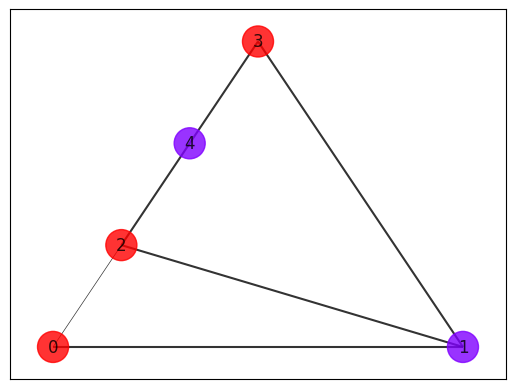

In [11]:
import matplotlib.pyplot as plt

result_parsed = most_probable_result.state["nodes"]
edge_widths = [
    is_cross_cut_edge(
        int(result_parsed[i]),
        int(result_parsed[j]),
    )
    + 0.5
    for i, j in G.edges
]
node_colors = [int(c) for c in result_parsed]
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    alpha=0.8,
    node_size=500,
    node_color=node_colors,
    width=edge_widths,
    cmap=plt.cm.rainbow,
)


## References

<a id='MaxCutWiki'>[1]</a>: [Maximum Cut Problem (Wikipedia)](https://en.wikipedia.org/wiki/Maximum_cut)
